# HW1: Logistic Regression

This class is about models and algorithms for discrete data. This homework will have all 3 ingredients:
* **Data**: the results from all college football games in the 2023 season
* **Model**: The *Bradely-Terry* model for predicting the winners of football game. The Bradley-Terry model is just logistic regression.
* **Algorithm**: We will implement two ways of fitting logistic regression: gradient descent and Newton's method

## The Bradley-Terry Model

In the Bradley-Terry Model, we give team $k$ a team-effect $\beta_k$. Basically, higher $\beta_k$ (relatively speaking), means that team $k$ is a better team.
The Bradley-Terry model formalizes this intution by modeling the log odds of team $k$ beating team $k'$ by the difference in their team effects, $\beta_k - \beta_{k'}$.

Let $i = 1,\ldots, n$ index games, and let $h(i) \in \{1,\ldots,K\}$ and $a(i) \in \{1,\ldots,K\}$ denote the indices of the home and away teams, respectively.
Let $Y_i \in \{0,1\}$ denote whether the home team won.
Under the Bradley-Terry model,
\begin{equation*}
  Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big),
\end{equation*}
where $\sigma(\cdot)$ is the sigmoid function. We can view this model as a logistic regression model with covariates $x_i \in \mathbb{R}^K$ where,
\begin{align*}
x_{i,k} &=
\begin{cases}
+1 &\text{if } h(i) = k \\
-1 &\text{if } a(i) = k \\
0 &\text{o.w.},
\end{cases}
\end{align*}
and parameters $\beta \in \mathbb{R}^K$.

## Data

We use the results of college football games in the fall 2023 season, which are available from the course github page and loaded for you below.

The data comes as a list of the outcomes of individual games. You'll need to wrangle the data to get it into a format that you can feed into the Bradley-Terry model.

In [14]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
allgames = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/data/01_allgames.csv")

## Problem 0: Preprocessing

Preprocess the data to drop games with nan scores, construct the covariate matrix $X$, construct the response vector $y$, and do any other preprocessing you find useful.

In [37]:
# your code here
allgames = allgames.dropna(subset=['Home Points', 'Away Points'])
teams = pd.concat([allgames['Home Team'], allgames['Away Team']]).unique()
team_to_index = {team: idx for idx, team in enumerate(teams)}
allgames['Home Index'] = allgames['Home Team'].map(team_to_index)
allgames['Away Index'] = allgames['Away Team'].map(team_to_index)
allgames = allgames.reset_index()
X = []
for _, row in allgames.iterrows():
    x = [0] * len(teams)
    x[row['Home Index']] = 1
    x[row['Away Index']] = -1
    X.append(x)

X = torch.tensor(X, dtype=torch.float32)

In [24]:
y = (allgames['Home Points'] > allgames['Away Points']).astype(int).values
y = torch.tensor(y, dtype=torch.float32)
y

tensor([1., 1., 1.,  ..., 1., 0., 1.])

## Problem 1: Loss function

Write a function to compute the loss, $L(\beta)$ defined be

\begin{equation*}
  L(\beta) = -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid x_i; \beta) + \frac{\gamma}{2} \| \beta \|_2^2
\end{equation*}
where $\gamma$ is a hyperparameter that controls the strength of your $\ell_2$ regularization.

You may want to use the `torch.distributions.Bernoulli` class.

In [232]:
# your code here
def loss(beta, X, y, gamma = 0):
    p = torch.sigmoid(torch.matmul(X, beta))
    Bernoulli = torch.distributions.Bernoulli(p)
    loss = -torch.mean(Bernoulli.log_prob(y)) + gamma * torch.norm(beta, p=2)**2 / 2
    return loss

## Problem 2: Gradient Descent

### Problem 2.1 Implementing and checking your gradients


Write a function to compute the gradient of the average negative log likelihood and check your output against the results obtained by PyTorch's automatic differentiation functionality.

In [233]:
# your code here
def gradient(beta, X, y, gamma = 0):
    p = torch.sigmoid(torch.matmul(X, beta))
    grad = -torch.matmul(X.T, y - p) / X.shape[0] + gamma * beta
    return grad

##### By the result below, we can see our gradient output works the same as PyTorch's automatic differentiation

In [272]:
torch.manual_seed(42)
beta = torch.randn(len(teams), requires_grad=True)
gamma = 0.1
loss1 = loss(beta, X, y, gamma) # Call the loss function and store the result
loss1.backward() # Call backward on the result of the loss function, not the function itself

manual_grad = gradient(beta, X, y, gamma)

# Compare gradients
print("\nDifference:\n", torch.round(torch.norm(manual_grad - beta.grad, p=2)**2))


Difference:
 tensor(0., grad_fn=<RoundBackward0>)


### Problem 2.2: Implement Gradient Descent


Now, use gradient descent to fit your Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements gradient descent to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curve of your algorithm and a brief discussion if it makes sense or not
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [226]:
# your code here (you can use multiple code and markdown cells to organize your answer)
def gradient_descent(X, y, gamma = 0, lr = 0.01, tol = 1e-7, max_iter = 10000):
    beta = torch.zeros(X.shape[1], requires_grad=False)
    losses = [loss(beta, X, y, gamma)]
    for i in tqdm(range(max_iter)):
      beta -= lr * gradient(beta, X, y, gamma)
      losses.append(loss(beta, X, y, gamma))
      if abs(losses[-1] - losses[-2]) < tol:
        break
    return beta, losses

In [160]:
def cross_validation(X, y, gamma_grid, k = 5, lr = 0.01):
  losses = [0] * len(gamma_grid)
  for i in range(len(gamma_grid)):
    total_loss_gamma = 0
    for j in range(k):
      # cut into 5
      test_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx % k == j])
      train_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx not in test_indices])
      test_X = X[test_indices]
      test_y = y[test_indices]
      train_X = X[train_indices]
      train_y = y[train_indices]
      beta, _ = gradient_descent(train_X, train_y, gamma_grid[i], lr)
      total_loss_gamma += loss(beta, test_X, test_y, gamma_grid[i])
    losses[i] = total_loss_gamma

  best_gamma = gamma_grid[losses.index(min(losses))]
  return best_gamma


In [191]:
gamma_grid = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
best_gamma = cross_validation(X, y, gamma_grid, lr = 0.3)

  0%|          | 21/5000 [00:00<00:10, 496.19it/s]


In [192]:
best_gamma

0.005

In [227]:
beta, losses = gradient_descent(X, y, 0.001, lr = 0.3)

 66%|██████▌   | 6613/10000 [00:18<00:09, 352.99it/s]


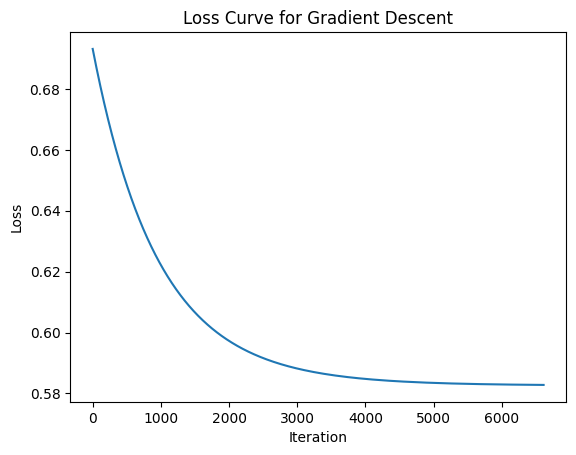

In [228]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Gradient Descent')
plt.show()

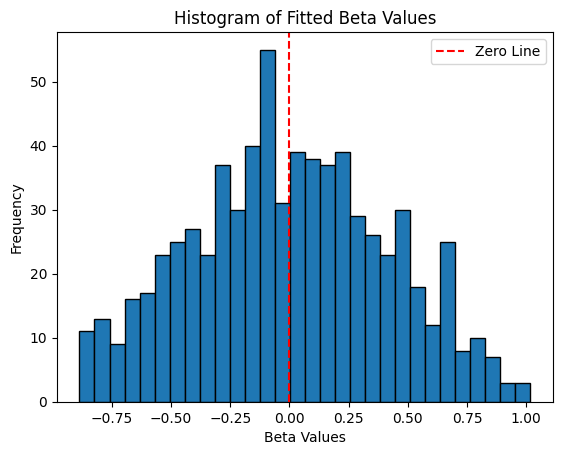

In [229]:
plt.hist(beta, bins=30, edgecolor='black')  # Add edgecolor for clear bar separation
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')  # Optional vertical reference line

# Add labels and title
plt.xlabel('Beta Values')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Beta Values')
plt.legend()

# Top 10 Team:
###### Washington, Michigan, Florida State, South Dakota State, Liberty, Alabama, Colorado Mines, Texas, Georgia, Johns Hopkins

#### This ranking make sense because it's the team with the top 10 highest $\beta_k$, by the model definition we have $$Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big)$$
since $\sigma(\cdot)$ is increasing function teams with higher $\beta$
will have a higher prob of winning against teams with lower
$\beta$.

In [230]:
top_10_indices = torch.topk(beta, k=10).indices
top_10_teams = [teams[idx] for idx in top_10_indices]
print(top_10_teams)

['Washington', 'Michigan', 'Florida State', 'South Dakota State', 'Liberty', 'Alabama', 'Colorado Mines', 'Texas', 'Georgia', 'Johns Hopkins']


## Problem 3: Newton's Method

Now, use Newton's method to fit your Bradley-Terry model to the provided data.


### Problem 3.1 The Hessian



#### Problem 3.1.1. Implement and check the Hessian
Write a function to compute the Hessian of the average negative log likelihood and check your answer against the output of `from torch.autograd.functional.hessian`.

In [255]:
# your code here
def hessian(beta, X, y, gamma = 0):
    p = torch.sigmoid(torch.matmul(X, beta))
    D = torch.diag(p * (1 - p))
    H = -torch.matmul(X.T, torch.matmul(D, X)) / X.shape[0] + gamma * torch.eye(X.shape[1])
    return H

#### By the result below, we can see our hessian output works the same as PyTorch's automatic hessian

In [271]:
manual_H = hessian(beta, X, y)
auto_H = torch.autograd.functional.hessian(lambda b: loss(b, X, y), beta)
print("\nDifference:\n", torch.round(torch.norm(manual_H - auto_H, p=2)**2))


Difference:
 tensor(0., grad_fn=<RoundBackward0>)


#### Problem 3.1.2: Positive definiteness

Compute the Hessian at the point $\beta = 0$ without regularization (set $\gamma = 0$). Unless you've done sort of pre-processing, it's probably singular.

In [274]:
# your code here
beta = torch.zeros(X.shape[1], requires_grad=False)
H = hessian(beta, X, y)
det = torch.linalg.det(H)
if torch.isclose(det, torch.tensor(0.0)):
    print("The matrix is singular (det = 0).")
else:
    print("The matrix is not singular (det ≠ 0).")

The matrix is singular (det = 0).


In [276]:
H

tensor([[-8.3635e-04,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -7.6666e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -8.3635e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -6.9696e-05,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -6.9696e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -6.9696e-05]])

#### Problem 3.1.3

Describe intuitively and mathematically what it means for the Hessian of the negative log likelihood to be singular in the context of this data and model

When the $\beta=0$ and $\gamma=0$, so the vector $p=\sigma(X\beta)=\sigma(\mathbf{0})=\mathbf{0.5}$, so in the hessian our $W=diag(p_1(1-p_1),....,p_k(1-p_k))=diag(0.25,....,0.25)$:
\begin{align}
H=\frac{1}{n}X^T W X +\gamma I=X^T W X
\end{align}
which it's a $\mathbf{0}_{k\times k}$ matrix, so it's singular.


#### Problem 3.1.4

Give a hypothesis for why the Hessian in this dataset and model is singular, and provide empirical evidence to support your hypothesis.

*your answer here*

In [ ]:
# your code here

#### Problem 3.1.5

Explain why the Hessian is invertible when $\gamma > 0$.

When $\gamma>0$, then for any $x\neq 0$ we have $\| x\|_2^2>0$
\begin{align}
x^THx=\frac{1}{n}x^T X^T W Xx +\gamma x^TIx=\frac{1}{n} \|W^{1/2}Xx \|_2^2 + \gamma \| x\|_2^2\geq \gamma \| x\|_2^2 > 0
\end{align}
so in this case $H$ is positive definite, which is invertible.

### Problem 3.2: Implement Newton's method

Now, use Newton's method to fit your $\ell_2$-regularized Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements Newton's method to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curves from Newton's method and from gradient descent, using the same regularization strength $\gamma$ and initialization $\beta_0$. Briefly discuss the results and compare their rates of convergence.
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [ ]:
# your code here (you can use multiple code and markdown cells to organize your answer)

## Problem 4: Model criticism and revision

Let's take another look the Bradley-Terry model from earlier and think about improvements we can make.


### Problem 4.1: Improvements to Bradley-Terry Model
Choose one way to improve the Bradley-Terry model. Discuss *a priori* why you think this change will improve the model and implement your change.

*your answer here*

### Problem 4.2: Evaluation
Assess whether or not your change was an improvement or not. Provide empirical evidence by evaluating performance on a held out test set and include at least one plot supporting your assessment.

*your answer here*

### Problem 4.3: Reflection
Reflecting on the analysis we've conducted in this assignemnt, which conference is best? Is there a significant difference? Please justify your answer.

*your answer here*

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.